In [5]:
from IPython.display import Latex
%matplotlib inline

# Introduction
Clustering is an unsupervised learning method where the true labels is not known or sparse with the goal to discover the true groupings. This is a commonly taught technique in machine learning and statistical inference. Many of you may know this is as *k-means* or *nearest neighbours*. A probabilistic approach to clustering requires incorporating prior knowledge to the algorithm, known as mixture models. Mixture models relax the assumptions of a single distribution in the data set. 

The remainder of this notebook will clarify the Bayesian approach to clustering and provide a simple implementation of the algorithm. To run this notebook interactively, please install IPython along with the dependencies as seen in the code.

## Bayesian Inference
Bayesian inference asserts Bayes' thorem to update the probability of some hypothesis as evidence. Traditional machine learning clustering algorithms such as *k-means* do not expose the underlying data structure, but assumes a stationary distribution. ML attempts to separate the data through some mean such as Euclidean's distance to measure the distance between data points. It assumes that close data points must be similar and share high correlation.

Mixture models attempts to estimate the data structure in the form of its density function. The foundation of Bayesian inference is Bayes' rule is

\begin{equation}
    P(Y|X) = \frac{P(X|Y)P(Y)}{P(X)}
\end{equation}


where $P(X|Y)$ is the **likelihood** and $P(Y)$ is the **prior**. The probability of the data $P(X)$ is independent of $Y$, hence, we can infer it by normalising $\sum_Y P(X|Y)P(Y)$. We will apply Bayes' rule to derive the mixture of models equation. 

We will refer heavily to several terms (e.g. prior and likelihood). The goal is to solve the posterior $P(Y|X)$ which can be computational intensive and intractable in some cases. There are many variations of mixture models in order to resolve this issue. But we will focus solely on sampling as a way to solve the posterior. 

We will also be referring to probability distributions, in particular, the **Normal** or **Gaussian** distribution $\mathcal{N(\mu, \sigma)}$ and **Dirichlet** distribution. The Gaussian distribution (i.e. imagine the bell curve) is the most widely used distribution in statistics. The Gaussian has two parameters that are easy to interpret: mean $\boldsymbol{\mu}$ and variance $\boldsymbol{\sigma}$. The Central Limit Theorem tells us that the sums of indepdent random variables have an approxiate Gaussian distribution as such a fine choice to model residual errors. Lastly, the mathematical form is elegant and simple to simplify complex distribution arithmetic. 

The **Dirichlet distribution** is a joint probability distribution such that the set of variables $\boldsymbol{D} = \{x_1, x_2,...,x_N\}$; it models the stochastic relationships between the variables. The Dirichlet distribution models distribution within distributions. The dirichlet distribution generalises the beta distribution for higher dimensions (e.g. multivariate distributions). 

## Multivariate Gaussian Distribution

Before presenting mixture models, we will discuss how to calculate the likelihood, prior, and posterior of a multivariate Gaussian. Every Gaussian has the parameters $\boldsymbol{\theta} = (\mu, \Sigma)$ where $\mu$ is the mean and $\Sigma$ is the covariance. To **infer these parameters**, we will assume the data has the form $x_i \sim \mathcal{N}(\mu, \Sigma)$ for $i$ = 1 : $N$ which we can represent as the matrix $\mathcal{X}$. Another assumption is there is no missing data. 

Recall that the multivariate Gaussian for $D$ dimensions is 
\begin{equation}
    \mathcal{N}(x|\mu, \Sigma)= \frac{1}{(2\pi)^{D/2} |\Sigma|^{1/2}} \exp{\bigg [-\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu)     \bigg ]}
\end{equation}

### Likelihood
The likelihood is given by
\begin{align}
    p(\mathcal{X}|\mu, \Sigma) & = \prod_{n=1}^N \mathcal{N}(x_n|\mu, \Sigma) \\
        & = \frac{1}{(2\pi)^{D/2} |\Sigma|^{1/2}} \exp{\bigg [-\frac{1}{2} \sum_{i=1}^N (x_i-\mu)^T \Sigma^{-1} (x_i-\mu) \bigg ]}
\end{align}

### Prior on parameters

The prior must be specially chosen in order to ease the calculation. As the likelihood is a multivariate Gaussian, the obvious choice **conjugate prior** is the *Normal-inverse-wishart* or NIW. 

The NIW distribution is composed of the multivariate normal and the *inverse-wishart* distribution. This is the beyond the scope of this tutorial. Let us represent NIW as
\begin{equation}
    p(\mu, \Sigma) = NIW(\mu, \Sigma| \boldsymbol{m}_0, \kappa_0, \nu_0, \boldsymbol{S}_0)
\end{equation}

### Posterior of Parameters: $\mu$ & $\Sigma$ 

We can shown the posterior of the parameters $\mu$ and $\Sigma$ as
\begin{align}
    p(\mu, \Sigma| \mathcal{X}) & \sim p(\mathcal{X}|\mu, \Sigma)p(\mu, \Sigma) \\
    &= NIW(\mu, \Sigma| \boldsymbol{m}_0, \kappa_0, \nu_0, \boldsymbol{S}_0)
\end{align}

This shows that the posterior is NIW distribution. 

### Posterior Predictive
Suppose we observe a new data point $x_*$, then the posterior predictive is

\begin{equation}
    p(x_*|\mathcal{X}) = \frac{p(x_*, \mathcal{X})}{p(\mathcal{X})}
\end{equation}

The denominator can be found by **marginalising the likelihood** of the data as the following

\begin{align}
 p(\mathcal{X}) &= \int_\mu \int_\Sigma p(\mathcal{X}, \mu,\Sigma) d\mu  d\Sigma \\
                &= \int_\mu \int_\Sigma p(\mathcal{X}| \mu,\Sigma) p(\mu,\Sigma) d\mu  d\Sigma
\end{align} 

reducing to the posterior of the parameters equation for $p(\mu, \Sigma| \mathcal{X})$.

The numerator is obtained to similar by marginalising the likelihood with the new data $x_*$. The final form is *equivalent* to the multivariate Student's t distribution:

\begin{equation}
    p(x_*|\mathcal{X}) = \mathcal{T}(x_* |m_N, \frac{\kappa_N +1}{\kappa_N(\nu_N - D +1)}S_n, \nu_n-D+1)
\end{equation}

We have provided a review of calculating the likelihood, prior, and posterior of a multivariate Gaussian. We will apply some of the principles to mixture models, but do not worry if you do not see the exact formulas being used in the code. We will be able to short hand some of the formulas.

## Gibbs Sampling

Another concept mixture model heavily relies on is **Gibbs sampling**. Suppose we have a sequence of observations $\boldsymbol{X} \in \{x_1, x_2,...,x_T\}$. The idea is to construct a Markov chain. A Markov chain assumes that $x_t$ captures all the relevant information for predicintg the future. In other words, the relevant information for $x_4$ is stored in the point previously $x_3$.

We are often interested in the long term distribution over states, the **stationary distribution** of the chain. Most of the times these distributions are high-dimensional, so we use **Markov chain Monte Carlo** or **MCMC**. The idea is to construct a Markov Chain on the state space of $\mathcal{X}$ whose station distribution, the target density of interest (i.e. this may be a prior). We perform a random walk on the state space so that we draw correlated samples $x_0, x_1,x_2,...$ to determine the joint distribution. We perform integration with respect to our target distributions.

## Mixture Models

In mathematics, there will always be multiple ways to perform an operation. As such, literature in this topic can be confusing. A mixture model (also referred to as **Gaussian mixture model**) can be broken into two variations -- finite and infinite. The finite model assumes as a parameter that the number of true clusters $\boldsymbol{K}$ will be provided as an argument whereas an infinite model discovers the "true" number of clusters in a dataset. An infinite mixture model is also called the **Dirichlet Process** mixture model. Mixture models is alternatively called Diriclet Processes because of how we sample from a joint distribution. The joint distribution is composed of other distributions making it a dirichlet distribution. 

For both models, there are several ways to discover the clusters. A common technique relies on maximum likelihood using the **Expectation Minimisation** to optimise the latent variables (e.g. mean, variance, and cluster probabilty of each cluster). The EM algorithm guarantees to converges to a local minima rather than a global. The EM is preferred if the parameters are fixed such as the number of true clusters is known. 

This is rarely the case in reality so we would prefer a more probablistic approach. Inference in Bayesian methods generally involves sampling. Sampling is a computationally tractablable way to calculate the posterior. Sampling requires generating samples from some posterior distribution $P(Y|X)$ in order to calculate the posterior marginal. In other words, we generate samples from some known distribution generally the Normal distribution to approximate our data set. Our focus is primiarly on Dirichlet Processes or Infinite Mixture Models using **Gibbs sampling**.

Mixture models exploits Gibbs sampling, a Markov Chain Monte Carlo (MCMC) algorithm. Given a joint probability distribution, we sample each variable conditioned on the values of all the other variables in the distribution. As we sample, we will eventually converge to the true distribution. In mixture models, we will be given a high dimensional joint distribution to sample in order to estimate the true distirbution and its parameters $\boldsymbol{\theta} = \{\theta_1, \theta_2,..., \theta_N\}$. We use the **Collapsed Gibss sampling** rather than full Gibbs sampling for we do not need to sample every parameter which we will return to later in the tutorial. 

## Gaussian Mixture Model for Finite Clusters

Let us detail the the Gaussian mixture model for the finite case before extending it to the infinite case (our main interest). Given some data set, there will be a cluster $k$ assigned to each data point $x_i$. Since this is finite, we will represent the data set as $\boldsymbol{X}=\{x_1, x2,...,x_N\}$ and $K = \in \{k1, k_2,...,k_N\}$ for the clusters. 
Each data point will have a latent variable $z_i \in \{1,2,...,K\}$ indicating which of the cluster component $x_i$ belongs to. We also have a *prior* $\pi_k=P(z_i=k)$ to indicate the probability that $x_i$ belongs to component $k$. We can say that given $z_i=k$, $x_i$ is genreated by the $k^{th}$ Gaussian mxiture component with mean $\mu_k$ and covariance matrix $\Sigma_k$

In the finite case, we will have $K$ clusters. We use the Dirichlet distribtuion for the mixture weights $\boldsymbol{\pi} = (\pi_1, \pi_2,...,\pi_K)$, 

\begin{equation}
P(\boldsymbol{\pi}|\boldsymbol{\alpha}) = Dir(\boldsymbol{\pi}|\boldsymbol{\alpha})
\end{equation}

where 
$$
Dir(x|\boldsymbol{\alpha}) = \frac{1}{B(\boldsymbol{\alpha})} \prod^K_{k=1} x_k^{\alpha_k -1}
$$

and $B(\boldsymbol{\alpha})$ is the normalising term which can be reduced to as the multinomial beta distribution

\begin{equation}
    B(\boldsymbol{\alpha}) = \frac{\prod_{k=1}^K \Gamma(\alpha_k)}{\Gamma(\alpha_0)}
\end{equation}

*NB: Given a likelihood distribution  __A__ and prior distribution __B__ , the resulting distribution when multiplied is the same as distribution __B__. In other words, __B__ is a conjugate prior to the likelihood __A__. We say that __B__ is the conjugate prior. In our context, the likelihood distribution is a multivariate Gaussian with a Dirichlet conjugate prior. Thus, the posterior distribution is Dirichlet. 

Conjugate prior is important as it reduces the complexity of the math when multiplying two distributions as seen with our joint probability distribution. 

## Joint Probability Distribution 
We model the joint distribution for mixture model as, 
\begin{equation}
    p(x,z,\mu,\Sigma, \pi) = p(x|z,\mu,\Sigma)p(z|\pi)p(\pi) \prod_{k=1}^K p(\mu_k)p(\Sigma_k)
\end{equation}

Since we use the conjugate prior, this allows us to integrate out the model parameters $\pi, \mu_k,$ and $\Sigma_k$.

\begin{align}
        p(z_i=k|z_{\setminus i}, \mathcal{X}, \alpha, \beta) & \propto p(z_i=k|z_{\setminus i}, \alpha, \beta)P(\mathcal{X}|z_i=k, z_{\setminus i}, \alpha, \beta) \\
        & \propto p(z_i=k|z_{\setminus i}, \alpha) p(x_i|X_{\setminus i}, z_i = k, z_{\setminus i},\beta)
\end{align}

More specifically, we sample $z$ for integrating out the model paraters do not affect the Markov chain, thus, we can draw independent samples. We are interested in finding the equations after the $\propto$.

### First term

The first term is the prior stating the probability of a cluster assignment given the the cluster assignments and the weight. This is can be shown as

\begin{equation}
    p(z_i=k|z_{\setminus i}, \alpha) = \frac{p(z|\alpha)}{p(z_{\setminus i}|\alpha)}
\end{equation}

This equation can be broken down by the numerator and denominator by finding an expression for the marginal $p(z|\alpha)$,
\begin{equation}
    p(z|\alpha) = \int_\pi p(z|\pi)p(\pi|\alpha)d\pi
\end{equation}

Recall the likelihood expression above for the first term in the integral has a similar form,
\begin{equation}
    p(z|\pi) = \prod_{k=1}^K \pi_k^{N_k}
\end{equation}

And the second term is simply the definition of a Dirichlet Prior as shown above. Subsituting and reducing produce
\begin{equation}
    P(z_i =k|z_i, \alpha) = \frac{N_k^{-i} + \alpha/K}{N-1+\alpha}
\end{equation}

### Second term
The second term is the predictive likelihood that the distribution of $x_i$ is according to cluster/component $k$ given the data currently in cluster $k$. Given the normal-inverse-wishart distribution, we assume unknown cluster means are normally distributed with hyperparameters means $\mu_0$ and variance $\sigma_0$.

By rewriting the second term as
$$ P(x_i|X_{k \setminus i}, \beta) = \frac{P(x_i,\mathcal{X}_{k \setminus i}| \beta)}{P(\mathcal{X}_{k \setminus i}| \beta)} = \frac{P(\mathcal{X}_k | \beta)}{P(\mathcal{X}_{k \setminus i}| \beta)} $$

Marginialising out $\beta$,

\begin{align}
     p(\mathcal{X}_k|\beta) &= \int_{\mu_k} \int_{\Sigma_k} p(\mathcal{X}_k, \mu_k,\Sigma_k|\beta) d\mu_k d\Sigma_k \\     
     &= \int_{\mu_k} \int_{\Sigma_k} p(\mathcal{X}_k| \mu_k,\Sigma_k) p(\mu_k,\Sigma_k|\beta) d\mu_k d\Sigma_k
\end{align} 

similar to how marginalisation of the likelihood for a multivariate Gaussian is performed. The equation reduces to the multivariate Student's t distribution as seen above for the posterior predictive distribution.


We have shown the derivation for finite Gaussian mixture models. We build the Markov chain by sampling the joint distribution $p(z_i=k|z_{\setminus i}, \mathcal{X}, \alpha, \beta)$. The posterior is now tractable with Gibbs sampling as our chosen distribution is high dimensional. Furthermore, sampling reduces our search space for we are interested in finding latent variables $z_i$ that matches our observations.


# Infinite Gaussian Mixture Model

The above has explained mixture model for a finite amount of clusters $K$. In reality, we will not know the true clusters in a data set as such we prefer a nonparametric approach where the algorithm will discover the true number of clusters. Luckily, the derivation for the inifinite Gaussian mixture model or Dirichlet Process is not difficult. 

Again, the joint distribution remains the same as

\begin{equation}
        p(z_i=k|z_{\setminus i}, \mathcal{X}, \alpha, \beta) \propto p(z_i=k|z_{\setminus i}, \alpha) p(x_i|X_{\setminus i}, z_i = k, z_{\setminus i},\beta)
\end{equation}

The first term changes for now we must consider the assumption that $K$ is infinite,

$$
p(z_i=k|z_{\setminus i}, \alpha)  = \left\{ \begin{array}{rl}
\frac{N_{k \setminus i}}{N + \alpha -1} &\mbox{ if $k$ is an existing component (i.e. $N_{k \setminus i}$ > 0} \\
\frac{\alpha}{N+\alpha-1} &\mbox{ if $k$ is a new cluster/component}
\end{array} \right.
$$

The second term corresponds to solving for the posterior predictive as above, and mainly remains the same as the finite case. Again, we use Gibbs sampling to create a Markov chain of the posterior. This will result into the true distributions of each cluster in our data set. 

## Implementation 

In [6]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

from scipy import stats
from collections import Counter

sns.set(color_codes=True)
np.random.seed(1234)

"""
    This is a simple implementation of Infinite Mixture Model or Dirichlet Process
    without optmisation. 
    
    author: Quan Le, quale@cisco.com
"""

class GaussianComponents(object):
    """
    The Gaussian cluster/component class that specifies a cluster's mean.
    """

    def __init__(self, id, mu=None, N=None):

        self.id = id
        self.mu = 0   # cluster means
        self.N = 0    # number of data points in cluster
        if (mu or N) is not None:
            self.mu = mu
            self.N = N

class DirichletProcess(object):
    """
        An Infinite Gaussian Mixture model or Dirichlet Process class.

    """
    def __init__(self, X, alpha, K=2):
        """
        The initalisation function for the DP. It takes the following arguments:

        X:
            a 1-D data vector

        alpha:
            the concentration parameter for the symmetric Dirichlet distribution 
            (emphasises the prior of a data point in a cluster)

        K:
            the number of clusters 
        """

        self.N = X.shape
        self.X = X
        self.alpha = alpha
        self.K = K
        self.cluster_ids = range(K)
        self.var = 0.01

        # randomly assign data points to a cluster
        self.assignments = np.random.randint(0, K, self.N)

        # set up the conjugate priors hyperparams
        self.conj_prior_mu = 0.0
        self.conj_prior_var = 1.0

        # assign each Gaussian object with a cluster ID
        self.components = {cluster_id: GaussianComponents(cluster_id) \
                                    for cluster_id in range(K)} 

        # initalise with even probability for each cluster                           
        self.pi = [self.alpha/K for _ in range(K)]

        self.update_components()


    def update_components(self):
        """ Update the components with a new mean (mu) and N """

        for i in self.components.keys():
            idx = np.where(self.assignments == i)
            mu = self.X[idx].mean()
            N = len(self.X[idx])
            self.components[i].mu = mu
            self.components[i].N = N

    def _create_component(self):
        """ Creates a cluster/component """

        self.K+=1
        cluster_id = max(self.components.keys()) + 1
        new_component = GaussianComponents(cluster_id)

        # add the new component to the dict
        self.components[cluster_id] = new_component
        return cluster_id


    def _remove_component(self):
        """ Remove a cluster """

        for id in self.components.keys():
            if self.components[id].N == 0:
                self.K -=1
                del self.components[id] # delete the component from the dict of components


    def _add_data(self, x, cluster_id):
        """ 
        Add a data point x to a cluster with the given id
        """
        z = self.components[cluster_id]

        #calculate the new mean
        update_mu = (z.mu*z.N + x*1.0) / (z.N+1) 

        #increment number of data points in that cluster
        update_N = z.N + 1                      

        self.components[cluster_id].mu = update_mu
        self.components[cluster_id].N = update_N

    def _remove_data(self, x, cluster_id):
        """
        Remove a data point x from the given cluster
        """

        z = self.components[cluster_id]

        #calculate the new mean 
        update_mu = (z.mu*z.N - x*1.0) / (z.N-1)
        update_N = z.N - 1

        self.components[cluster_id].mu = update_mu
        self.components[cluster_id].N = update_N


    def log_prob_cluster_assignment(self, cluster_id):
        """
        Calculate the log probability of a data point being assigned to the given cluster and
        the current cluster assignment. This is the first term in the equation descirbed in the notebook.
        """
        pi = np.log(self.alpha)
        if cluster_id != -999: 

            # update the cluster with the new probability if an already existing cluster
            pi = np.log(self.components[cluster_id].N)
        return pi

    def log_predictive_likelihood(self, x, cluster_id):
        """
        Calculate the predictive log likelihood that the distribution of the data point x
        belongs to the given cluster. This is the second term.
        """

        # new cluster created for params, never added to list
        if cluster_id == -999: 
            component = GaussianComponents(-999, mu=0, N=0) # -999
        else:
            component = self.components[cluster_id]

        posterior_var = 1.0 / ( (component.N*1.0/self.var) + (1./ self.conj_prior_var) )
        pred_mu = posterior_var * ( (self.conj_prior_mu*1.0 / self.conj_prior_var) + \
                                        (component.N * component.mu * 1.0 / self.var) )
        pred_sigma = np.sqrt(posterior_var + self.var)
        return stats.norm(pred_mu, pred_sigma).logpdf(x)


    def gibbs_sampling(self, n_iter):
        """
        The Collapsed Gibbs sampling to sample data. 
        """

        for i_iter in xrange(n_iter):
            print 'running sampling at iteration:', i_iter
            data_pair = zip(self.X, self.assignments)
            for idx, (x_i, z_i) in enumerate(data_pair):

                # remove the data point
                self._remove_data(x_i, z_i)
                self._remove_component()

                # calculate prob X[i] belonging to each component
                scores = {}
                cluster_ids = self.components.keys() + [-999] # -999 refers to a new cluster made
                for cid in cluster_ids:
                    scores[cid] = self.log_predictive_likelihood(x_i, cid)
                    scores[cid] += self.log_prob_cluster_assignment(cid) # logarithmic so we add for multiplication
                scores = {cid:np.exp(score) for cid, score in scores.iteritems()}
                normalised = 1.0 / sum(scores.values())
                scores = {cid:score * normalised for cid, score in scores.iteritems()}

                # sample new assignment from the scores from marginal distribution
                probs = scores.values()
                labels = scores.keys()
                assign_cluster = np.random.choice(labels, p=probs) # sample
                if assign_cluster == -999:
                    assign_cluster = self._create_component()

                # add the new cluster assignemnt for x_i
                self.assignments[idx] = int(assign_cluster)
                self._add_data(x_i, assign_cluster)

        # return final clustering assignments or labels
        return self.assignments


################################ Utility Function ###########################

def draw_hist(X, labels, it=None):
    """
    Utility function to draw the histogram of the clusters. Can be used to draw 
    all iterations from the Collapsed Gibbs sampling. 
    """

    df = pd.DataFrame({'data':X, 'cluster_assignment':labels}).groupby(by='cluster_assignment')['data']
    hist_data = [df.get_group(cid).tolist() for cid in df.groups.keys()]
    for d in hist_data:
        sns.distplot(d, kde=False)

    if it is None:
        t = 'Original Histogram'
    else:
        t = "Histogram on Iteration " + str(it)
    plt.title(t)
    plt.draw()

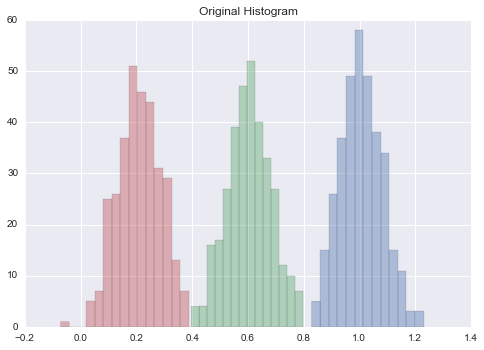

In [7]:
data_fn = "test_data.pkl"
data = pickle.load(open(data_fn, "rb"))
X = data[:,0] * -1.0
z_label = data[:,1]  # true clustering
draw_hist(X, z_label)

running sampling at iteration: 0
running sampling at iteration: 1
running sampling at iteration: 2
running sampling at iteration: 3
running sampling at iteration: 4


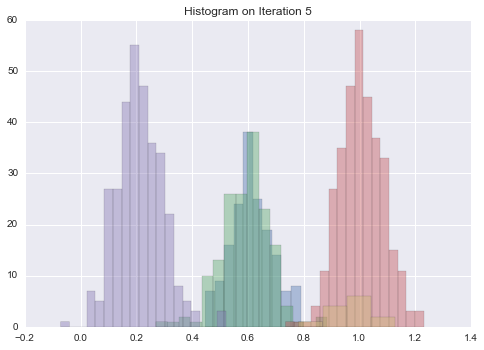

In [9]:
model = DirichletProcess(X, 0.5, K=2)
n_iter = 5
prob_z = model.gibbs_sampling(n_iter)
draw_hist(X, prob_z, n_iter)

running sampling at iteration: 0
running sampling at iteration: 1
running sampling at iteration: 2
running sampling at iteration: 3
running sampling at iteration: 4
running sampling at iteration: 5
running sampling at iteration: 6
running sampling at iteration: 7
running sampling at iteration: 8
running sampling at iteration: 9
running sampling at iteration: 10
running sampling at iteration: 11
running sampling at iteration: 12
running sampling at iteration: 13
running sampling at iteration: 14
running sampling at iteration: 15
running sampling at iteration: 16
running sampling at iteration: 17
running sampling at iteration: 18
running sampling at iteration: 19
running sampling at iteration: 20
running sampling at iteration: 21
running sampling at iteration: 22
running sampling at iteration: 23
running sampling at iteration: 24
running sampling at iteration: 25
running sampling at iteration: 26
running sampling at iteration: 27
running sampling at iteration: 28
running sampling at iter

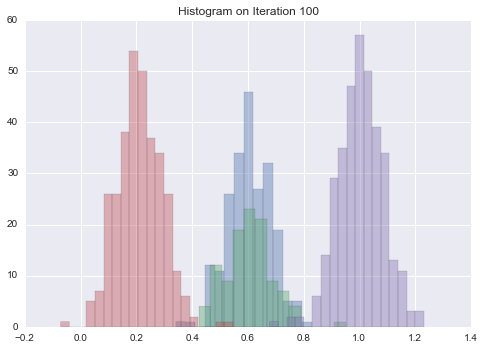

In [5]:
model = DirichletProcess(X, 0.1, K=2)
n_iter = 100
prob_z = model.gibbs_sampling(n_iter)
draw_hist(X, prob_z, n_iter)

# Networking Context

This tutorial has shown an explanation of Bayesian inference on clustering. But, we have not provided contextual details and how we may leverage Bayesian inference at Cisco and in networking. Clustering is a powerful way to drive correlations from similar events. In other words, we are able to identifiy related cascading network events that may cause an abnormal behaviour in the network.

A prime example of abnormal behaviour is BGP flaps. BGP flaps have many potential causes along with cascading effects to the network as such a prime candidate for clustering. BGP flaps cause may also stem from related events. Performing the mixture model algorithm on a given dataset that contains information SNMP and TCP network statistics, the algorithm indicates three clusters as seen above. 

In the red cluster, the grouped data shows that memory and CPU utilisation are rather high values. The policing buffer in the control plane notifies a shift in the priorities of the scheduling queue. 

The green/blue cluster groups data with changing route counters. We observe the counter flucautes drastically rather than staying static where some values increase to 50 routes and in the next 3 seconds decrease to 20 routes. We also observe that the link_changed_state boolean is False for the data set in this cluster. We can conclude from these observations that a link flap has occured, and that it is a local change. 

Finally, the purple cluster groups the data by adjacency nodes too have been decreasing. This indicates that neighbouring nodes have gone down, and is a result of a remote change to the network.

With these three clusters, we can conclude that the BGP flaps has been caused by three events. The red cluster being issues in the **control plane**, the green/blue cluster shows issues with the **link flaps**, and the purple cluster is the result of **remote change**. We also establish further correlation in that link flaps drive number of routes as well. The cluster here have some independent events as well as mutual events. Discovering such relationships allows to pursue even more fine grain data. Knowing the relationship of link flaps and routes allows us idenfitiy the actual equipments observing these changes. 

# Notations

| Notation      	           | Definition           	     |
|----------------------	       |-----------------------------|
| $\mathcal{X}$ 	           | data set             	     |
| $D$             	           | dimensions of data   	     |
| $N$             	           | number of data       	     |
| $N_k$             	       | count of component $k$ in z |
| $K$             	           | number of components 	     |
| $z = (z_1, z_2,...,z_N)$     | latent states for observations|
| $\mu$                        | mean of multivariate Guassian|
| $\Sigma$                     | covariance matrix of multivariate Guassian, a subcript $\Sigma_k$ is the covariance for a particular component 
| $\alpha = (\alpha_1, \alpha_2,...,\alpha_K)$ | parameter for Dirichlet prior on the mixing weights|
| $\beta = (m_0, \kappa_0, \nu_0, S_0)$        | parameters for GIW
| $\boldsymbol{m}_0$                           |prior mean for $\mu$
|$\kappa_0$                                    | how strongly we believe the prior of $\mu$
|$\nu_0$                                       | how strongly we believe the prior of $\Sigma$
|$\boldsymbol{S}_0$                            | prior mean for $\Sigma$

# References

Kamper, Herman. "Gibbs sampling for fitting finite and infinite Gaussian mixture models." (2013). (https://github.com/kamperh/bayes_gmm)

Murphy, Kevin P. Machine learning: a probabilistic perspective. MIT press, 2012.

Murphy, Kevin P. "Conjugate Bayesian analysis of the Gaussian distribution." def 1.2σ2 (2007): 16.

https://github.com/tdhopper/notes-on-dirichlet-processes

Many thanks to **Drew Pletcher** for his explanations of networking basics in order to draw the relationships between this algorithm and networking.


<!--bibtex

@ENTRY TYPE{CITATION ID,
    FIELD 1 = {source specific information},
    FIELD 2 = {source specific informatio},
    FIEL 3 = {source specific informatio},
    FIELD 4 = {source specific informatio}
}

-->
